# Module

In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score

import optuna
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [2]:
%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [3]:
np.random.seed(2024)
random.seed(2024)

# Data

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
all_df = pd.concat([train, test], sort=False).reset_index(drop=True)

In [5]:
train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

# Skewness

In [7]:
numerical_columns = train.dtypes[train.dtypes != 'object']
numerical_columns = [col for col in numerical_columns.index.tolist() if col not in ['id', 'Premium Amount']]
numerical_columns

['Age',
 'Annual Income',
 'Number of Dependents',
 'Health Score',
 'Previous Claims',
 'Vehicle Age',
 'Credit Score',
 'Insurance Duration']

In [8]:
train.describe()

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount
count,1.200000e+06,1.181295e+06,1.155051e+06,1.090328e+06,1.125924e+06,835971.000000,1.199994e+06,1.062118e+06,1.199999e+06,1.200000e+06
mean,5.999995e+05,4.114556e+01,3.274522e+04,2.009934e+00,2.561391e+01,1.002689,9.569889e+00,5.929244e+02,5.018219e+00,1.102545e+03
std,3.464103e+05,1.353995e+01,3.217951e+04,1.417338e+00,1.220346e+01,0.982840,5.776189e+00,1.499819e+02,2.594331e+00,8.649989e+02
min,0.000000e+00,1.800000e+01,1.000000e+00,0.000000e+00,2.012237e+00,0.000000,0.000000e+00,3.000000e+02,1.000000e+00,2.000000e+01
25%,2.999998e+05,3.000000e+01,8.001000e+03,1.000000e+00,1.591896e+01,0.000000,5.000000e+00,4.680000e+02,3.000000e+00,5.140000e+02
50%,5.999995e+05,4.100000e+01,2.391100e+04,2.000000e+00,2.457865e+01,1.000000,1.000000e+01,5.950000e+02,5.000000e+00,8.720000e+02
75%,8.999992e+05,5.300000e+01,4.463400e+04,3.000000e+00,3.452721e+01,2.000000,1.500000e+01,7.210000e+02,7.000000e+00,1.509000e+03
max,1.199999e+06,6.400000e+01,1.499970e+05,4.000000e+00,5.897591e+01,9.000000,1.900000e+01,8.490000e+02,9.000000e+00,4.999000e+03


In [9]:
print('The skewness of columns')
print(train[numerical_columns].skew())

The skewness of columns
Age                    -0.012532
Annual Income           1.470357
Number of Dependents   -0.013255
Health Score            0.282187
Previous Claims         0.905321
Vehicle Age            -0.020409
Credit Score           -0.113573
Insurance Duration     -0.008793
dtype: float64


> Skewness Analysis and Transformation

- **Annual Income**:  
  - Skewness = **1.47** (Highly skewed).  
  - Log transformation or square root transformation is recommended to normalize the distribution.

- **Previous Claims**:  
  - Skewness = **0.91** (Moderately skewed).  
  - Further analysis of the data distribution is required.  
  - Consider transformations or binning based on the observed distribution and business context.

In [10]:
def plot_transform(df, col):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    sns.histplot(df[col], kde=True, ax=ax[0])
    ax[0].set_title(f'{col} Distribution Before Log Transformation', fontsize=14)
    skew_before = df[col].skew()
    ax[0].text(0.7, 0.9, f'Skewness: {skew_before:.2f}', transform=ax[0].transAxes, fontsize=12, color='red')

    sns.histplot(np.log1p(df[col]), kde=True, ax=ax[1])
    ax[1].set_title(f'{col} Distribution After Log Transformation', fontsize=14)
    skew_after = np.log1p(df[col]).skew()
    ax[1].text(0.7, 0.9, f'Skewness: {skew_after:.2f}', transform=ax[1].transAxes, fontsize=12, color='red')
    plt.show()

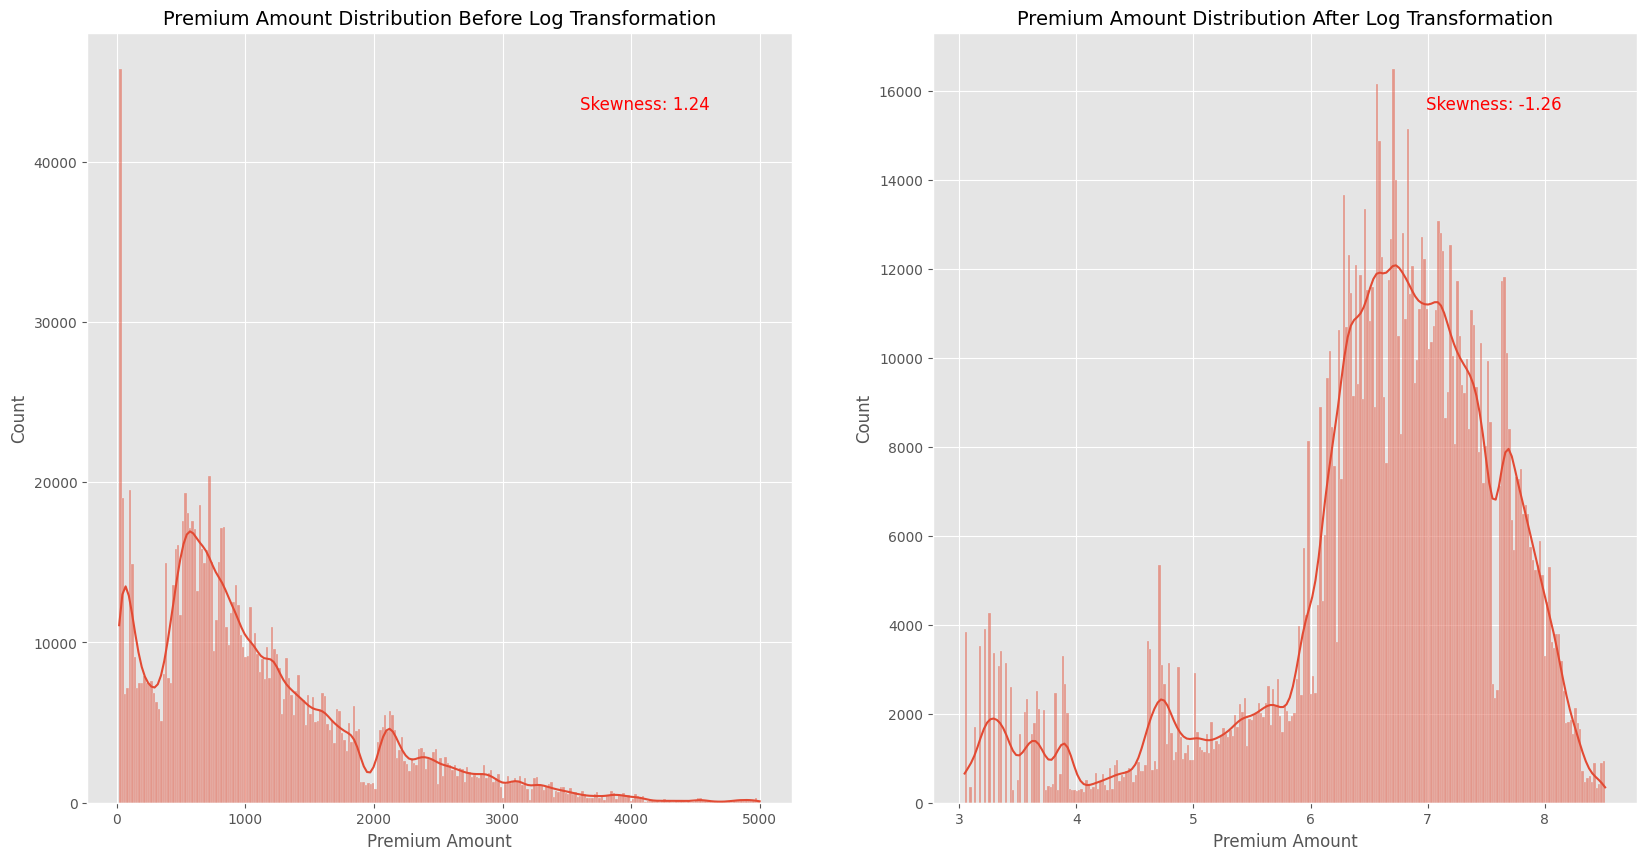

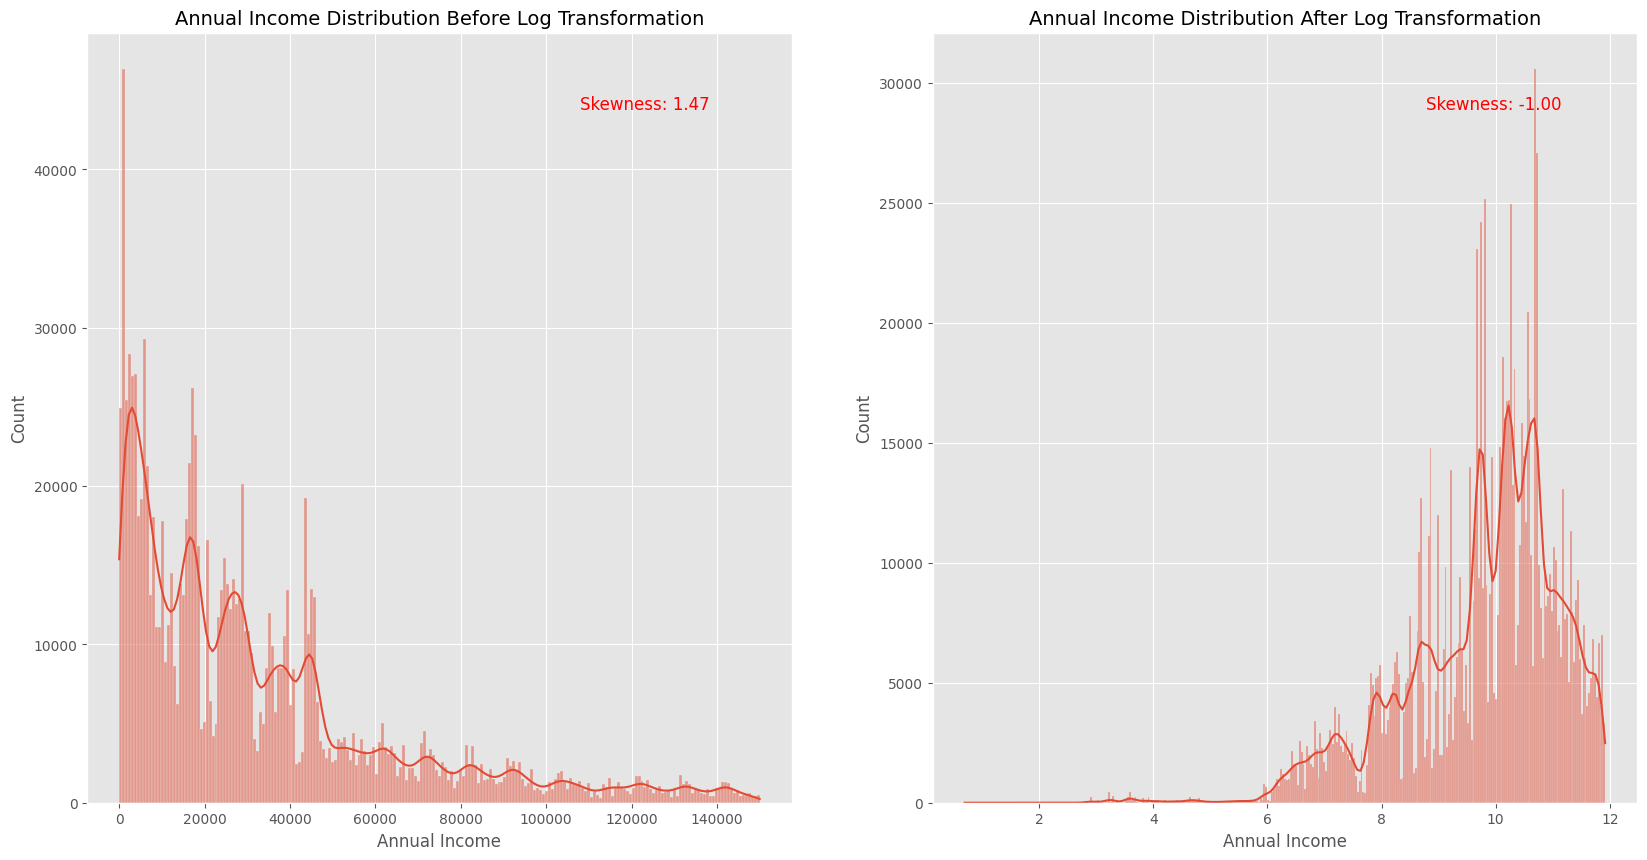

In [11]:
for col in ['Premium Amount', 'Annual Income']:
    plot_transform(train, col)

In [12]:
pt = PowerTransformer(method='yeo-johnson') # yeo-johnson : 음수값 포함, box-cox : 양수값만
pt.fit(train[['Premium Amount']])
all_df['transformed_Premium_Amount'] = pt.transform(all_df[['Premium Amount']])
print(pd.Series(all_df['transformed_Premium_Amount']).skew())

-0.0578129153515697


In [13]:
all_df['log_Premium_Amount'] = np.log1p(all_df['Premium Amount'])

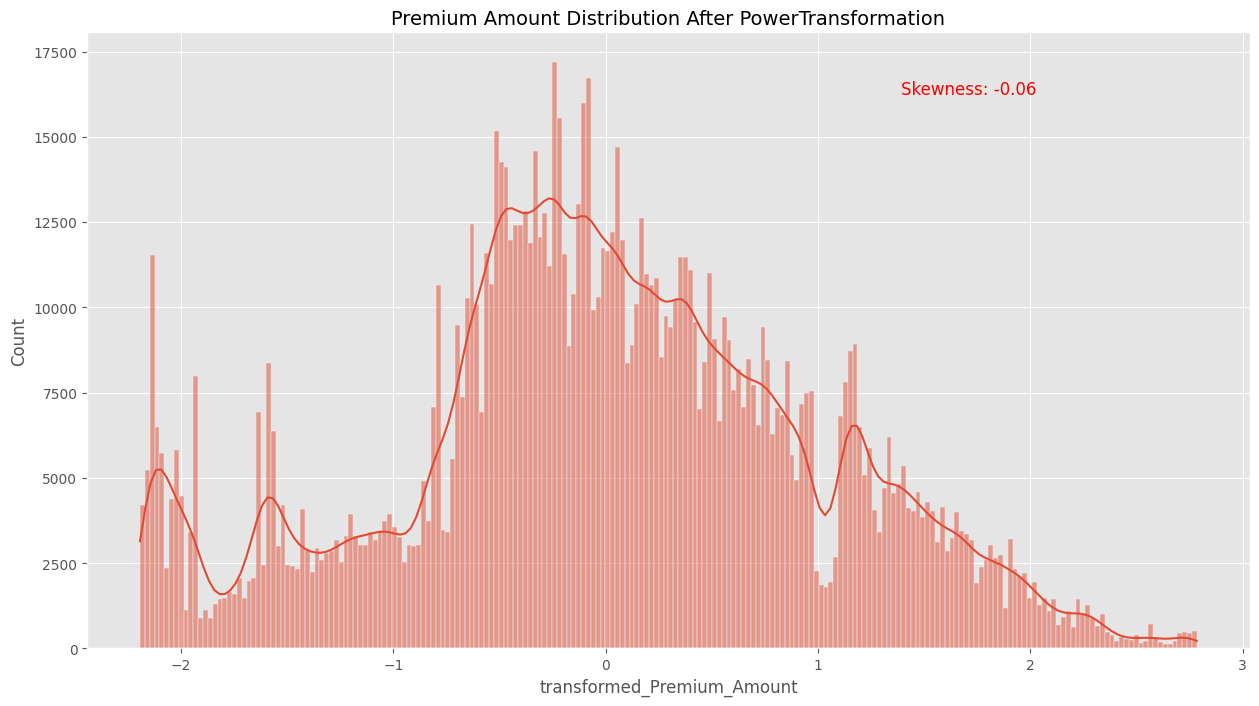

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(all_df['transformed_Premium_Amount'], kde=True, discrete=False)
ax.set_title(f'Premium Amount Distribution After PowerTransformation', fontsize=14)
skew_pt = all_df['transformed_Premium_Amount'].skew()
ax.text(0.7, 0.9, f'Skewness: {skew_pt:.2f}', transform=ax.transAxes, fontsize=12, color='red')
plt.show()

In [15]:
income_pt = PowerTransformer(method='yeo-johnson') # yeo-johnson : 음수값 포함, box-cox : 양수값만
income_pt.fit(train[['Annual Income']])
all_df['transformed_Annual_Income'] = income_pt.transform(all_df[['Annual Income']])
print(pd.Series(all_df['transformed_Annual_Income']).skew())

-0.08129960132028968


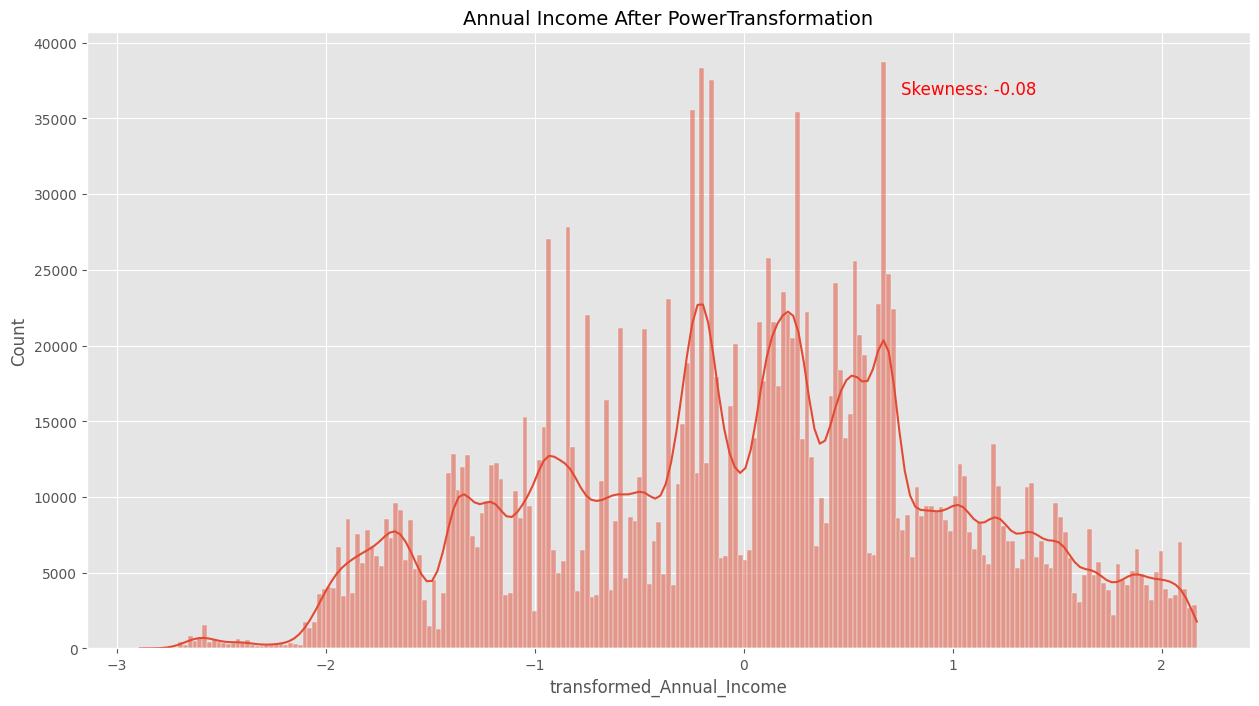

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(all_df['transformed_Annual_Income'], kde=True, discrete=False)
ax.set_title(f'Annual Income After PowerTransformation', fontsize=14)
skew_pt = all_df['transformed_Annual_Income'].skew()
ax.text(0.7, 0.9, f'Skewness: {skew_pt:.2f}', transform=ax.transAxes, fontsize=12, color='red')
plt.show()

# Date

In [17]:
def date(df):

    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month_name'] = df['Policy Start Date'].dt.month_name()
    df['Day_of_week'] = df['Policy Start Date'].dt.day_name()
    df['Week'] = df['Policy Start Date'].dt.isocalendar().week
    df['Year_sin'] = np.sin(2 * np.pi * df['Year'])
    df['Year_cos'] = np.cos(2 * np.pi * df['Year'])
    min_year = df['Year'].min()
    max_year = df['Year'].max()
    df['Year_sin'] = np.sin(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Year_cos'] = np.cos(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12) 
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)  
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    df['Group']=(df['Year']-2020)*48+df['Month']*4+df['Day']//7
    
    df.drop('Policy Start Date', axis=1, inplace=True)

    return df

# Apply the date function to both datasets
all_df = date(all_df)

all_df.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,transformed_Premium_Amount,log_Premium_Amount,transformed_Annual_Income,Year,Day,Month,Month_name,Day_of_week,Week,Year_sin,Year_cos,Month_sin,Month_cos,Day_sin,Day_cos,Group
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,Poor,No,Weekly,House,2869.0,1.671351,7.962067,-0.596487,2023,23,12,December,Saturday,51,-9.510565e-01,0.309017,-2.449294e-16,1.000000e+00,-0.998717,-0.050649,195
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,Average,Yes,Monthly,House,1483.0,0.632658,7.302496,0.336563,2023,12,6,June,Monday,24,-9.510565e-01,0.309017,1.224647e-16,-1.000000e+00,0.651372,-0.758758,169
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,Good,Yes,Weekly,House,567.0,-0.466682,6.342121,0.140781,2023,30,9,September,Saturday,39,-9.510565e-01,0.309017,-1.000000e+00,-1.836970e-16,-0.201299,0.979530,184
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,Poor,Yes,Daily,Apartment,765.0,-0.168181,6.641182,2.088459,2024,12,6,June,Wednesday,24,-2.449294e-16,1.000000,1.224647e-16,-1.000000e+00,0.651372,-0.758758,217
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,Poor,Yes,Weekly,House,2022.0,1.086793,7.612337,0.555622,2021,1,12,December,Wednesday,48,5.877853e-01,-0.809017,-2.449294e-16,1.000000e+00,0.201299,0.979530,96


# Missing Values

In [18]:
train = all_df[~all_df['Premium Amount'].isnull()]
test = all_df[all_df['Premium Amount'].isnull()]

train.shape, test.shape

((1200000, 36), (800000, 36))

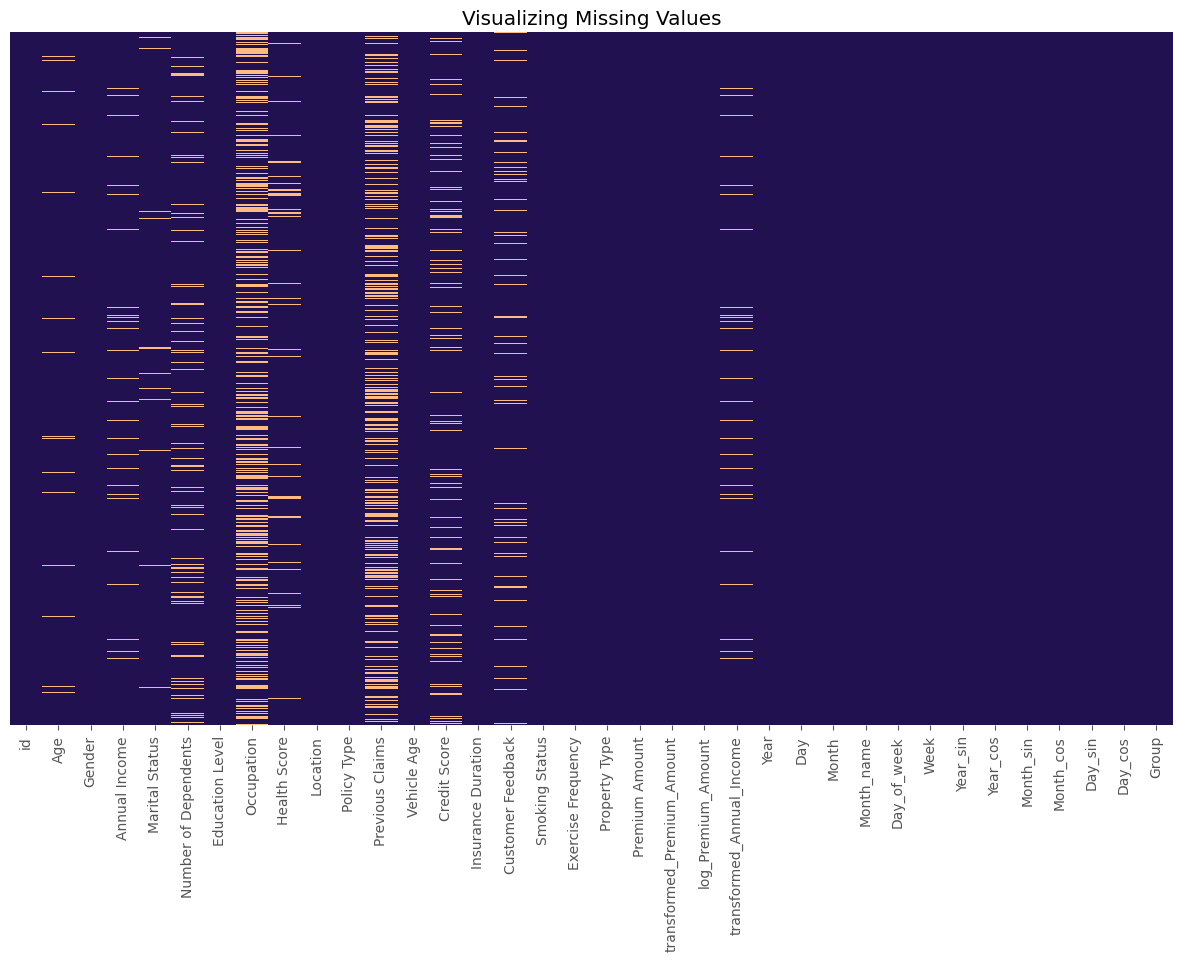

In [19]:
plt.figure(figsize=(15,9))
plt.title("Visualizing Missing Values")
sns.heatmap(train.isnull(), cbar=False, cmap=sns.color_palette('magma'), yticklabels=False);
plt.show()

In [20]:
print('Ratio of NaN Values : ')
for col in train.columns.ravel():
    print(f'{col} : {(len(train[train[col].isnull()]) / len(train[col])) * 100:.2f}%')

Ratio of NaN Values : 
id : 0.00%
Age : 1.56%
Gender : 0.00%
Annual Income : 3.75%
Marital Status : 1.54%
Number of Dependents : 9.14%
Education Level : 0.00%


Occupation : 29.84%
Health Score : 6.17%
Location : 0.00%
Policy Type : 0.00%
Previous Claims : 30.34%
Vehicle Age : 0.00%
Credit Score : 11.49%
Insurance Duration : 0.00%
Customer Feedback : 6.49%
Smoking Status : 0.00%
Exercise Frequency : 0.00%
Property Type : 0.00%
Premium Amount : 0.00%
transformed_Premium_Amount : 0.00%
log_Premium_Amount : 0.00%
transformed_Annual_Income : 3.75%
Year : 0.00%
Day : 0.00%
Month : 0.00%
Month_name : 0.00%
Day_of_week : 0.00%
Week : 0.00%
Year_sin : 0.00%
Year_cos : 0.00%
Month_sin : 0.00%
Month_cos : 0.00%
Day_sin : 0.00%
Day_cos : 0.00%
Group : 0.00%


In [21]:
train['Occupation'].value_counts(dropna=False)

Occupation
NaN              358075
Employed         282750
Self-Employed    282645
Unemployed       276530
Name: count, dtype: int64

In [22]:
train['Previous Claims'].value_counts(dropna=False)

Previous Claims
NaN    364029
0.0    305433
1.0    300811
2.0    167661
3.0     49011
4.0     10668
5.0      2018
6.0       302
7.0        58
8.0         8
9.0         1
Name: count, dtype: int64

# Outliers

In [23]:
Q1 = train['Premium Amount'].quantile(0.25)
Q3 = train['Premium Amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 개수 확인
outliers = train[(train['Premium Amount'] < lower_bound) | (train['Premium Amount'] > upper_bound)]
print('Premium Amount')
print(f'Number of Outliers: {len(outliers)}')
print(f"Ratio of Outliers: {(len(outliers) / len(train['Premium Amount'])) * 100}%")

Premium Amount
Number of Outliers: 49320
Ratio of Outliers: 4.109999999999999%


In [24]:
Q1 = train['transformed_Premium_Amount'].quantile(0.25)
Q3 = train['transformed_Premium_Amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 개수 확인
outliers = train[(train['transformed_Premium_Amount'] < lower_bound) | (train['transformed_Premium_Amount'] > upper_bound)]
print('transformed_Premium_Amount')
print(f'Number of Outliers: {len(outliers)}')
print(f"Ratio of Outliers: {(len(outliers) / len(train['transformed_Premium_Amount'])) * 100}%")

transformed_Premium_Amount
Number of Outliers: 4528
Ratio of Outliers: 0.37733333333333335%


In [42]:
Q1 = train['log_Premium_Amount'].quantile(0.25)
Q3 = train['log_Premium_Amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 개수 확인
outliers = train[(train['log_Premium_Amount'] < lower_bound) | (train['log_Premium_Amount'] > upper_bound)]
print('log_Premium_Amount')
print(f'Number of Outliers: {len(outliers)}')
print(f"Ratio of Outliers: {(len(outliers) / len(train['log_Premium_Amount'])) * 100}%")

log_Premium_Amount
Number of Outliers: 86730
Ratio of Outliers: 7.227500000000001%


> Effect of PowerTransformer on Skewness and Outliers  

- PowerTransformer reduced **skewness**, making the distribution closer to normal.  
- The number of **outliers** significantly decreased after transformation.  
- This improves **data stability** and supports better **model performance**.  

# Preprocessing

In [26]:
features = train.columns.drop(['id', 'Premium Amount', 'transformed_Premium_Amount', 'log_Premium_Amount', 'Annual Income'])
features

Index(['Age', 'Gender', 'Marital Status', 'Number of Dependents',
       'Education Level', 'Occupation', 'Health Score', 'Location',
       'Policy Type', 'Previous Claims', 'Vehicle Age', 'Credit Score',
       'Insurance Duration', 'Customer Feedback', 'Smoking Status',
       'Exercise Frequency', 'Property Type', 'transformed_Annual_Income',
       'Year', 'Day', 'Month', 'Month_name', 'Day_of_week', 'Week', 'Year_sin',
       'Year_cos', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'Group'],
      dtype='object')

In [27]:
object_columns = train[features].select_dtypes(include='object').columns.to_list()
numerical_columns = train[features].select_dtypes(exclude='object').columns.to_list()

In [28]:
num_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

cat_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessors = ColumnTransformer(
    transformers=[
        ('num', num_preprocessor, numerical_columns),
        ('cat', cat_preprocessor, object_columns),
    ]
)

In [29]:
train_prep = preprocessors.fit_transform(train[features])
test_prep = preprocessors.transform(test)

# Model

In [30]:
y = train['log_Premium_Amount']

In [31]:
x_train, x_val, y_train, y_val = train_test_split(train_prep, y, test_size=0.1, random_state=2024)

## Hyperparmeter

In [32]:
def objective(trial):
    param = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int("num_leaves", 10, 300),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "max_depth": trial.suggest_int("max_depth", -1, 12),  # -1 means no limit
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-4, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-4, 10.0, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.001, 0.1),
        "device_type": "cpu",
        "seed" : 2024,
        'verbose':-1 # no warning msg
    }

    dtrain = lgb.Dataset(x_train, label=y_train)
    dval = lgb.Dataset(x_val, label=y_val, reference=dtrain)

    callbacks=[
        lgb.log_evaluation(period=50)
    ]

    model = lgb.train(
        param,
        dtrain,
        num_boost_round=300,
        valid_sets=[dtrain, dval],
        valid_names=['train', 'valid'],
        callbacks=callbacks
    )

    y_val_pred = model.predict(x_val, num_iteration=model.best_iteration)
    rmse = root_mean_squared_error(y_val, np.maximum(y_val_pred, 0))
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

[I 2024-12-23 17:23:57,612] A new study created in memory with name: no-name-0805d2e1-6531-47eb-8541-71a4d88dc327


[50]	train's rmse: 4.9786	valid's rmse: 4.97687
[100]	train's rmse: 5.22751	valid's rmse: 5.22575
[150]	train's rmse: 5.2053	valid's rmse: 5.20357
[200]	train's rmse: 5.17062	valid's rmse: 5.1689
[250]	train's rmse: 5.08379	valid's rmse: 5.0821
[300]	train's rmse: 5.03131	valid's rmse: 5.02964


[I 2024-12-23 17:27:10,583] Trial 0 finished with value: 5.029637434304955 and parameters: {'boosting_type': 'dart', 'num_leaves': 260, 'learning_rate': 0.0012350601153328872, 'feature_fraction': 0.64989608593134, 'bagging_fraction': 0.601316018910705, 'bagging_freq': 12, 'min_data_in_leaf': 30, 'max_depth': 0, 'lambda_l1': 0.4412578966693157, 'lambda_l2': 0.0075827735750255455, 'min_gain_to_split': 0.011862707676053418}. Best is trial 0 with value: 5.029637434304955.


[50]	train's rmse: 5.04778	valid's rmse: 5.04601
[100]	train's rmse: 5.37148	valid's rmse: 5.36968
[150]	train's rmse: 5.44392	valid's rmse: 5.44212
[200]	train's rmse: 5.48024	valid's rmse: 5.47844
[250]	train's rmse: 5.49234	valid's rmse: 5.49053
[300]	train's rmse: 5.4803	valid's rmse: 5.4785


[I 2024-12-23 17:29:49,293] Trial 1 finished with value: 5.478495194950309 and parameters: {'boosting_type': 'dart', 'num_leaves': 294, 'learning_rate': 0.00024940245550093446, 'feature_fraction': 0.7702174357387237, 'bagging_fraction': 0.8062506258585705, 'bagging_freq': 6, 'min_data_in_leaf': 13, 'max_depth': 12, 'lambda_l1': 2.5296121002218075, 'lambda_l2': 0.004672806267549277, 'min_gain_to_split': 0.035589916398179454}. Best is trial 0 with value: 5.029637434304955.


[50]	train's rmse: 4.64628	valid's rmse: 4.64462
[100]	train's rmse: 4.57363	valid's rmse: 4.57199
[150]	train's rmse: 4.18686	valid's rmse: 4.18531
[200]	train's rmse: 3.91728	valid's rmse: 3.91582
[250]	train's rmse: 3.53584	valid's rmse: 3.53449
[300]	train's rmse: 3.39904	valid's rmse: 3.39774


[I 2024-12-23 17:31:55,521] Trial 2 finished with value: 3.397739872235376 and parameters: {'boosting_type': 'dart', 'num_leaves': 258, 'learning_rate': 0.0062219394077094045, 'feature_fraction': 0.7826208373060437, 'bagging_fraction': 0.7051475087702362, 'bagging_freq': 12, 'min_data_in_leaf': 26, 'max_depth': 8, 'lambda_l1': 0.004902582972371653, 'lambda_l2': 1.5884956163240764, 'min_gain_to_split': 0.08068609466893556}. Best is trial 2 with value: 3.397739872235376.


[50]	train's rmse: 1.0537	valid's rmse: 1.058
[100]	train's rmse: 1.04309	valid's rmse: 1.04979
[150]	train's rmse: 1.03905	valid's rmse: 1.04811
[200]	train's rmse: 1.03647	valid's rmse: 1.04774
[250]	train's rmse: 1.03437	valid's rmse: 1.04765
[300]	train's rmse: 1.03239	valid's rmse: 1.0476


[I 2024-12-23 17:32:45,411] Trial 3 finished with value: 1.04760066711265 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 265, 'learning_rate': 0.019900082468040366, 'feature_fraction': 0.8816331238830531, 'bagging_fraction': 0.85473386652637, 'bagging_freq': 11, 'min_data_in_leaf': 29, 'max_depth': 10, 'lambda_l1': 0.0018545909408421955, 'lambda_l2': 0.12487609516517066, 'min_gain_to_split': 0.04078459509737622}. Best is trial 3 with value: 1.04760066711265.


[50]	train's rmse: 4.33252	valid's rmse: 4.33098
[100]	train's rmse: 4.014	valid's rmse: 4.01259
[150]	train's rmse: 3.4036	valid's rmse: 3.40245
[200]	train's rmse: 3.03772	valid's rmse: 3.03678
[250]	train's rmse: 2.57145	valid's rmse: 2.57086
[300]	train's rmse: 2.45009	valid's rmse: 2.44964


[I 2024-12-23 17:35:58,919] Trial 4 finished with value: 2.449644297041434 and parameters: {'boosting_type': 'dart', 'num_leaves': 127, 'learning_rate': 0.0113817458717491, 'feature_fraction': 0.6096817347128042, 'bagging_fraction': 0.9714676941822054, 'bagging_freq': 12, 'min_data_in_leaf': 65, 'max_depth': 10, 'lambda_l1': 0.011712739046387087, 'lambda_l2': 0.006921118032792019, 'min_gain_to_split': 0.010805656506975687}. Best is trial 3 with value: 1.04760066711265.


[50]	train's rmse: 1.04559	valid's rmse: 1.04867
[100]	train's rmse: 1.04337	valid's rmse: 1.04788
[150]	train's rmse: 1.0419	valid's rmse: 1.04787
[200]	train's rmse: 1.0405	valid's rmse: 1.04783
[250]	train's rmse: 1.03922	valid's rmse: 1.04778
[300]	train's rmse: 1.03795	valid's rmse: 1.0478


[I 2024-12-23 17:36:22,557] Trial 5 finished with value: 1.0478018025000726 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'learning_rate': 0.061886995837152514, 'feature_fraction': 0.9090832296171187, 'bagging_fraction': 0.6446387940789581, 'bagging_freq': 12, 'min_data_in_leaf': 15, 'max_depth': 10, 'lambda_l1': 0.00034748097011508484, 'lambda_l2': 2.613731171515569, 'min_gain_to_split': 0.022003911807422213}. Best is trial 3 with value: 1.04760066711265.


[50]	train's rmse: 1.0916	valid's rmse: 1.09388
[100]	train's rmse: 1.08802	valid's rmse: 1.09045
[150]	train's rmse: 1.08426	valid's rmse: 1.08683
[200]	train's rmse: 1.08135	valid's rmse: 1.08407
[250]	train's rmse: 1.07858	valid's rmse: 1.08144
[300]	train's rmse: 1.07611	valid's rmse: 1.07912


[I 2024-12-23 17:37:10,240] Trial 6 finished with value: 1.0791178354543922 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 260, 'learning_rate': 0.0016585758742684456, 'feature_fraction': 0.688108077701935, 'bagging_fraction': 0.6901567334468434, 'bagging_freq': 11, 'min_data_in_leaf': 93, 'max_depth': 10, 'lambda_l1': 0.03272251006705384, 'lambda_l2': 0.05578987562141131, 'min_gain_to_split': 0.017196553594679448}. Best is trial 3 with value: 1.04760066711265.


[50]	train's rmse: 1.09209	valid's rmse: 1.09428
[100]	train's rmse: 1.08887	valid's rmse: 1.09112
[150]	train's rmse: 1.08555	valid's rmse: 1.08785
[200]	train's rmse: 1.08286	valid's rmse: 1.08522
[250]	train's rmse: 1.08049	valid's rmse: 1.08291
[300]	train's rmse: 1.07818	valid's rmse: 1.08065


[I 2024-12-23 17:37:52,882] Trial 7 finished with value: 1.0806499974657866 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 224, 'learning_rate': 0.0010997241270711898, 'feature_fraction': 0.8349253645718292, 'bagging_fraction': 0.6824568227496217, 'bagging_freq': 7, 'min_data_in_leaf': 48, 'max_depth': 8, 'lambda_l1': 0.09769740878253505, 'lambda_l2': 0.0071037356438185695, 'min_gain_to_split': 0.019284958867539302}. Best is trial 3 with value: 1.04760066711265.


[50]	train's rmse: 4.83113	valid's rmse: 4.82944
[100]	train's rmse: 4.92964	valid's rmse: 4.92795
[150]	train's rmse: 4.72792	valid's rmse: 4.7263
[200]	train's rmse: 4.56891	valid's rmse: 4.56734
[250]	train's rmse: 4.31833	valid's rmse: 4.31683
[300]	train's rmse: 4.2095	valid's rmse: 4.20804


[I 2024-12-23 17:41:01,948] Trial 8 finished with value: 4.208041466225477 and parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'learning_rate': 0.0033917223136948533, 'feature_fraction': 0.8325065382569123, 'bagging_fraction': 0.9998833596646919, 'bagging_freq': 10, 'min_data_in_leaf': 68, 'max_depth': 8, 'lambda_l1': 0.01638730138418981, 'lambda_l2': 0.0004558727621883329, 'min_gain_to_split': 0.08175842346896461}. Best is trial 3 with value: 1.04760066711265.


[50]	train's rmse: 1.09201	valid's rmse: 1.09418
[100]	train's rmse: 1.08892	valid's rmse: 1.09113
[150]	train's rmse: 1.08634	valid's rmse: 1.08858
[200]	train's rmse: 1.08432	valid's rmse: 1.0866
[250]	train's rmse: 1.08252	valid's rmse: 1.08483
[300]	train's rmse: 1.08089	valid's rmse: 1.08323


[I 2024-12-23 17:41:22,736] Trial 9 finished with value: 1.083226276443385 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 290, 'learning_rate': 0.002619441956287897, 'feature_fraction': 0.7624757623672898, 'bagging_fraction': 0.8823250457075005, 'bagging_freq': 10, 'min_data_in_leaf': 36, 'max_depth': 3, 'lambda_l1': 0.002240901848254494, 'lambda_l2': 0.12102441639592638, 'min_gain_to_split': 0.06791962105418929}. Best is trial 3 with value: 1.04760066711265.


In [33]:
study.best_params, study.best_value

({'boosting_type': 'gbdt',
  'num_leaves': 265,
  'learning_rate': 0.019900082468040366,
  'feature_fraction': 0.8816331238830531,
  'bagging_fraction': 0.85473386652637,
  'bagging_freq': 11,
  'min_data_in_leaf': 29,
  'max_depth': 10,
  'lambda_l1': 0.0018545909408421955,
  'lambda_l2': 0.12487609516517066,
  'min_gain_to_split': 0.04078459509737622},
 1.04760066711265)

## Train

In [35]:
best_params = study.best_params

dtrain = lgb.Dataset(x_train, label=y_train)
dval = lgb.Dataset(x_val, label=y_val, reference=dtrain)

callbacks = [
    lgb.early_stopping(200),
    lgb.log_evaluation(period=50)
]

model_lgb = lgb.train(
    best_params,
    dtrain,
    num_boost_round=1500,
    valid_sets=[dtrain, dval],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

Training until validation scores don't improve for 200 rounds
[50]	train's l2: 1.11031	valid's l2: 1.11927
[100]	train's l2: 1.08792	valid's l2: 1.10182
[150]	train's l2: 1.07951	valid's l2: 1.09852
[200]	train's l2: 1.07417	valid's l2: 1.09768
[250]	train's l2: 1.06992	valid's l2: 1.09753
[300]	train's l2: 1.06589	valid's l2: 1.09741
[350]	train's l2: 1.06189	valid's l2: 1.09734
[400]	train's l2: 1.0583	valid's l2: 1.09735
[450]	train's l2: 1.05479	valid's l2: 1.09735
[500]	train's l2: 1.05119	valid's l2: 1.09727
[550]	train's l2: 1.04776	valid's l2: 1.09727
[600]	train's l2: 1.04432	valid's l2: 1.09737
[650]	train's l2: 1.04117	valid's l2: 1.09746
[700]	train's l2: 1.03794	valid's l2: 1.09753
Early stopping, best iteration is:
[507]	train's l2: 1.05073	valid's l2: 1.09725


# Evaluation

In [36]:
y_val_pred = model_lgb.predict(x_val)

rmse = root_mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"\nPerformance Metrics:\n{'-'*30}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


Performance Metrics:
------------------------------
RMSE: 1.0475
MAE: 0.7443
R²: 0.0895


/tmp/ipykernel_172145/640111917.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette="coolwarm")


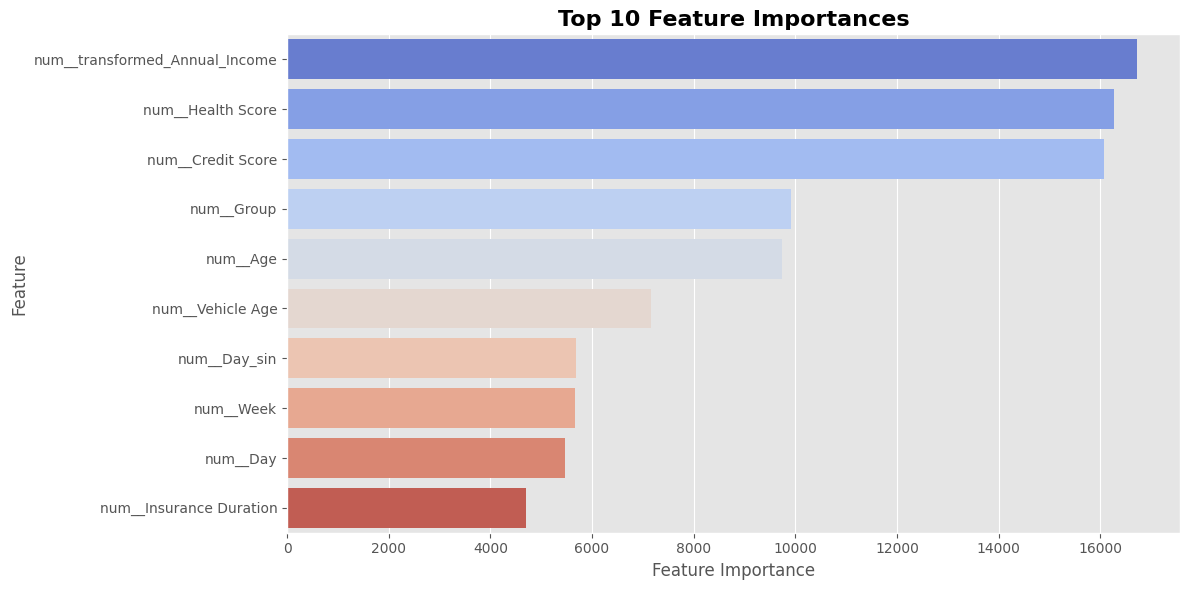

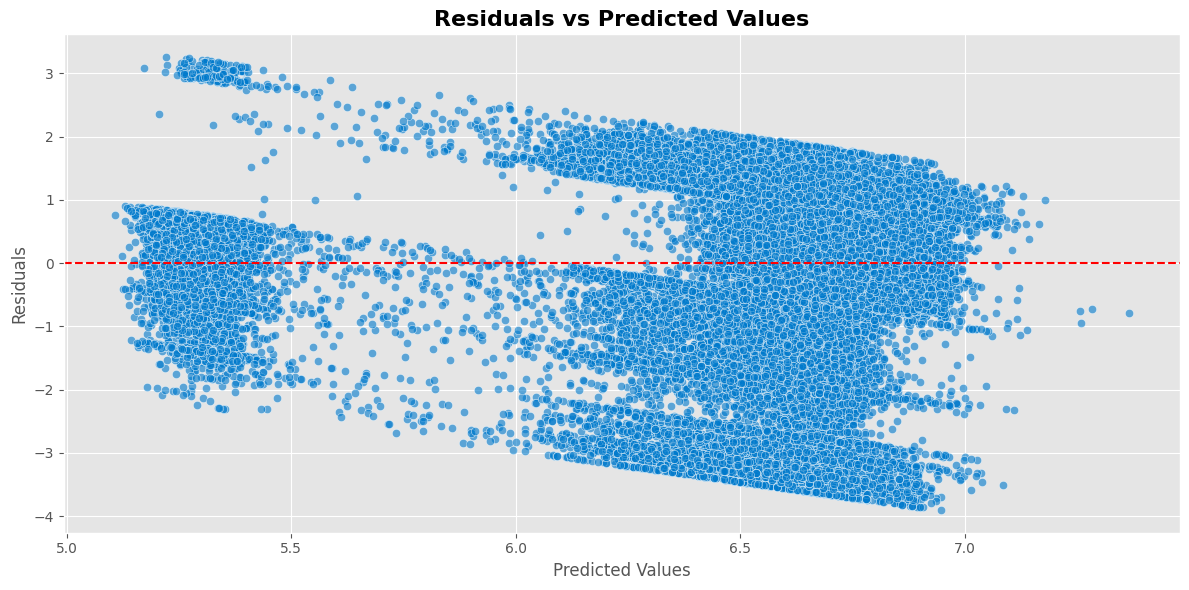

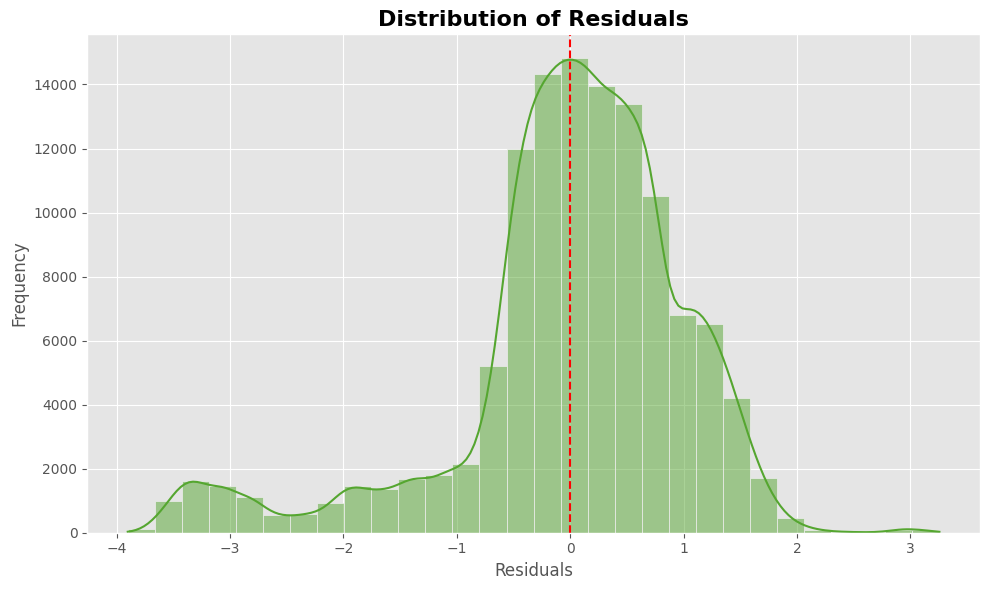

In [37]:
importances = model_lgb.feature_importance(importance_type='split')  # or 'gain'
features = preprocessors.get_feature_names_out()
sorted_indices = importances.argsort()[::-1]

importance_df = pd.DataFrame({
    'Feature': [features[i] for i in sorted_indices],
    'Importance': importances[sorted_indices]
})

plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette="coolwarm")
plt.title("Top 10 Feature Importances", fontsize=16, fontweight='bold')
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

residuals = y_val - y_val_pred

plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val_pred, y=residuals, alpha=0.6, color="#007acc")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Residuals vs Predicted Values", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color="#55a630")
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Distribution of Residuals", fontsize=16, fontweight='bold')
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

# Submission

In [38]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.head()

,id,Premium Amount
0,1200000,1102.545
1,1200001,1102.545
2,1200002,1102.545
3,1200003,1102.545
4,1200004,1102.545


In [39]:
preds = model_lgb.predict(test_prep)
preds_exp = np.expm1(preds)
submission['Premium Amount'] = preds_exp
submission.head(20)

,id,Premium Amount
0,1200000,828.611550
1,1200001,809.724135
2,1200002,801.525991
3,1200003,806.348250
4,1200004,759.213784
5,1200005,789.149362
6,1200006,966.839345
7,1200007,699.179165
8,1200008,190.531669
9,1200009,844.951614


In [40]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              800000 non-null  int64  
 1   Premium Amount  800000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 12.2 MB


In [41]:
submission.to_csv('./data/02_3_submission.csv', index=False)
!kaggle competitions submit -c playground-series-s4e12 -f "./data/02_3_submission.csv" -m "02_3_submission"

100%|██████████████████████████████████████| 19.8M/19.8M [00:00<00:00, 45.2MB/s]
Successfully submitted to Regression with an Insurance Dataset

> Public Score : 
- 1.06555 : with "Annual Income'
- 1.06559 : remove 'Annual Income'
- 1.06596 : metrc - rmsle
- 1.04506 : target - log, income - powertransform
    - 334 / 1693

> **Public Score Comparison**

- **Baseline Model:**
  - **Public Score:** 1.04849  
  - **Rank:** 498 / 1653  

- **Second Model (Feature Engineering + PowerTransformer):**
  - **Public Score:** 1.04506  
  - **Rank:** 334 / 1693  

---

> **Key Improvements**

1. **Date Features Added:**
   - Extracted date components (year, month, day) and applied **sin** and **cos** transformations to capture **cyclic patterns**.  

2. **Annual Income Preprocessing:**
   - Addressed **skewness** and **outliers** in the 'Annual Income' column using **PowerTransformer** for better normalization.  

3. **Target Value Transformation:**
   - Initially applied **PowerTransformer** to the target value, but it caused **Public Score deterioration** (RMSLE ~ 1.06).  
   - Switched to **log transformation** for the target, which better aligned with the **RMSLE evaluation metric**.  

---

> **Results Analysis**

- The **second model outperformed the baseline** in terms of **Public Score** and **ranking**, showing that  
  **feature engineering** and **data preprocessing** improved the model's ability to generalize.  
- Despite better **validation metrics**, the initial target transformation mismatch caused a drop in Public Score,  
  highlighting the importance of **consistency between preprocessing and evaluation metrics**.  
- Reverting to **log transformation** for the target resolved this issue and yielded a **better rank (334/1693)**.  
